In [1]:
import os, sys
import math
from copy import deepcopy
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 2.0.1+cu117.  CUDA version: 11.7


In [ ]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl.data import DGLDataset
from dgl.dataloading import GraphDataLoader
from torch.utils.data import Subset
from torch.utils.data.sampler import SubsetRandomSampler

import dgl.function as fn

from ogb.graphproppred import DglGraphPropPredDataset, Evaluator
from ogb.graphproppred.mol_encoder import BondEncoder, AtomEncoder

In [4]:
dgl.__version__

'0.9.1post1'

In [5]:
device = 'cuda' if th.cuda.is_available() else 'cpu'
device = th.device(device)
device

device(type='cuda')

In [6]:
from utils import repeat_experiments, norm_plot, train, test

In [8]:
# https://docs.dgl.ai/tutorials/blitz/6_load_data.html#creating-a-dataset-for-graph-classification-from-csv
class MolHIVDataset(DGLDataset):
    def __init__(self):
        super().__init__(name='ogbg-molhiv')
        
    def _load(self):
        self.dataset = DglGraphPropPredDataset(name="ogbg-molhiv", root = 'dataset/')
        self.split_idx = self.dataset.get_idx_split()
        print(self.dataset.meta_info)
        
    def __getitem__(self, i):
        return self.dataset.graphs[i], self.dataset.labels[i]

    def __len__(self):
        return len(self.dataset.graphs)

In [9]:
dataset = MolHIVDataset()
len(dataset) #41127

num tasks                                                                1
eval metric                                                         rocauc
download_name                                                          hiv
version                                                                  1
url                      http://snap.stanford.edu/ogb/data/graphproppre...
add_inverse_edge                                                      True
data type                                                              mol
has_node_attr                                                         True
has_edge_attr                                                         True
task type                                            binary classification
num classes                                                              2
split                                                             scaffold
additional node files                                                 None
additional edge files    

41127

In [10]:
# create train/val/test split dataloaders
split_idx = dataset.split_idx

train_sampler = SubsetRandomSampler(split_idx['train'])
val_subset = Subset(dataset, split_idx['valid'])
test_subset = Subset(dataset, split_idx['test'])


In [11]:
bs = 32
train_dataloader = GraphDataLoader(
    dataset, sampler=train_sampler, batch_size=bs, drop_last=False)
val_dataloader = GraphDataLoader(
    val_subset, shuffle=False, batch_size=bs, drop_last=False)
test_dataloader = GraphDataLoader(
    test_subset, shuffle=False, batch_size=bs, drop_last=False)

In [12]:
len(val_subset), len(test_subset)

(4113, 4113)

In [13]:
it = iter(train_dataloader)
batch = next(it)

In [14]:
batch

[Graph(num_nodes=706, num_edges=1512,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]])]

In [38]:
dgl.unbatch(batch[0])

[Graph(num_nodes=22, num_edges=48,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=25, num_edges=52,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=20, num_edges=40,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=23, num_edges=52,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=23, num_edges=50,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes={'feat': Scheme(shape=(3,), dtype=torch.int64)}),
 Graph(num_nodes=11, num_edges=20,
       ndata_schemes={'feat': Scheme(shape=(9,), dtype=torch.int64)}
       edata_schemes=

In [16]:
# ndata - node data
batch[0].ndata['feat']

tensor([[7, 0, 2,  ..., 2, 0, 0],
        [5, 0, 4,  ..., 2, 0, 0],
        [5, 0, 3,  ..., 1, 1, 1],
        ...,
        [6, 0, 3,  ..., 1, 1, 1],
        [5, 0, 3,  ..., 1, 1, 1],
        [7, 0, 1,  ..., 1, 0, 0]])

In [17]:
# edata - edge data
batch[0].edata['feat']

tensor([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [1, 0, 1],
        [3, 0, 1],
        [3, 0, 1]])

see [AtomEncoder](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/graphproppred/mol_encoder.py#L7) and [BondEncoder](https://github.com/snap-stanford/ogb/blob/68a303f320220cda859e83e3a8660f2b9debedf6/ogb/graphproppred/mol_encoder.py#L27)

In [18]:
emb_dim = 300

In [19]:
# Three parts:
## GIN layer
## Node convolution
## Graph convolution

## Graph Isomorphic Network layer

[How Powerful are Graph Neural Networks?](https://arxiv.org/abs/1810.00826)

$$\mathbf{h}_i^{(l+1)} = \text{MLP}[ (1 + \epsilon) \cdot \mathbf{h}_i^{(l)} + \sum_{j \in \mathcal{N}_i} \mathbf{h}_j^{(l)} ]$$

see https://github.com/snap-stanford/ogb/blob/master/examples/graphproppred/mol/conv.py#L31

$$\mathbf{h}_i^{(l+1)} = \text{MLP}[ (1 + \epsilon) \cdot \mathbf{h}_i^{(l)} + \sum_{j \in \mathcal{N}_i} \text{ReLU}(\mathbf{h}_j^{(l)} + \mathbf{e}_{ij}) ]$$



In [20]:
# copy_{u} - source node
# copy_{v} - destination, neighbour node

class GINLayer(nn.Module):
    def __init__(self, emb_dim):
        super(GINLayer, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, 2*emb_dim), 
            nn.BatchNorm1d(2*emb_dim), 
            nn.ReLU(), 
            nn.Linear(2*emb_dim, emb_dim) #from above
        )
        self.eps = nn.Parameter(th.FloatTensor([0]))
        

    def reset_parameters(self): # reset the parameters of the MLP
        # MLP
        for layer in self.mlp:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        # EPS
        nn.init.constant_(self.eps, 0.)
        
    def extra_repr(self):
        # Add "eps" to the string representation
        return f'(eps): nn.Parameter'
        
    def forward(self, g, x_node, x_edge):
        """
        g : The graph used for message passing
        x_node : AtomEncodings
        x_edge : BondEncodings
        """
        
        with g.local_scope():
            # Store edge features to 'bond' key in g.edata
            g.edata['bond'] = x_edge
            # Store node features to 'x' key in g.ndata
            g.srcdata['x'] = x_node
            
            # calculate the right part h_i = sum_j( F.relu (h_j + e_ij) )
                
            ## 1. take the sum
            g.apply_edges( # see https://docs.dgl.ai/api/python/dgl.function.html#dgl-built-in-function
                fn.u_add_e('x', 'bond', 'm')
            )
            ##2. apply ReLU
            g.edata['m'] = F.relu(g.edata['m'])
            
            ## 3. sum the modified messages https://docs.dgl.ai/en/1.0.x/generated/dgl.DGLGraph.update_all.html
            g.update_all(
                fn.copy_e('m', 'm'), # creating messages
                fn.sum('m', 'mp'), # sending messages to message passing
            )
            ## extract the final output into variable "h_mp"
            h_mp = g.dstdata['mp'] # will be used in the next layer
                    
        # GIN update equation
        out = self.mlp((1 + self.eps) * x_node + h_mp)

        return out

In [21]:
gin = GINLayer(emb_dim)
gin

GINLayer(
  (eps): nn.Parameter
  (mlp): Sequential(
    (0): Linear(in_features=300, out_features=600, bias=True)
    (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=300, bias=True)
  )
)

In [22]:
#362101
sum(p.numel() for p in gin.parameters())

362101

In [23]:
#https://github.com/dmlc/dgl/blob/master/examples/mxnet/gin/gin.py

gin(
    batch[0], 
    AtomEncoder(emb_dim)(batch[0].ndata['feat']), 
    BondEncoder(emb_dim)(batch[0].edata['feat'])
)

/home/ki/repos/dgl2/venv/lib/python3.10/site-packages/dgl/backend/pytorch/tensor.py:352: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), "Cannot convert view " \


tensor([[-0.9681, -0.6240, -0.1038,  ..., -0.6000, -0.9485, -0.7573],
        [ 0.3010, -0.6838,  0.5443,  ..., -0.0686, -0.7225, -0.6984],
        [ 0.0730,  0.0048, -0.0595,  ..., -0.2102, -0.4386, -0.5446],
        ...,
        [ 0.4252,  0.1886, -0.2115,  ..., -0.2981, -0.3695, -0.0432],
        [ 0.1600, -0.1270, -0.0809,  ..., -0.1951, -0.2563, -0.3816],
        [-0.1221, -0.7057,  0.3895,  ..., -0.7057, -0.6778, -0.4727]],
       grad_fn=<AddmmBackward0>)

In [24]:
## Node convolution
class NodeGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, dropout):
        super(NodeGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.atom_encoder = AtomEncoder(emb_dim)
        self.bond_encoder = BondEncoder(emb_dim)
        
        self.convs = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(GINLayer(emb_dim))
            self.batch_norms.append(nn.BatchNorm1d(emb_dim))
    
    def reset_parameters(self):
        
        for emb in self.atom_encoder.atom_embedding_list: # Atom embeddings
            nn.init.xavier_uniform_(emb.weight.data)
        
        for emb in self.bond_encoder.bond_embedding_list: # Bond embeddings
            nn.init.xavier_uniform_(emb.weight.data)
        
        # reset parameters for the GIN and batch norm layers
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.batch_norms:
            bn.reset_parameters()
    
    def forward(self, g):
        """        
        (node_embeddings, edge_embeddings) -> GIN -> Batch Norm -> ReLU -> Dropout
        """
        
        # Convert integer categorical features to embeddings
        h = self.atom_encoder(g.ndata['feat']) # initial node embeddings
        edge_embedding = self.bond_encoder(g.edata['feat']) # edge embeddings
        
        for layer in range(self.num_layers):
            h = self.convs[layer](g, h, edge_embedding)
            h = self.batch_norms[layer](h)
            if layer == self.num_layers - 1:
                #remove relu for the last layer
                h = F.dropout(h, self.dropout, training=self.training)
            else:
                h = F.dropout(F.relu(h), self.dropout, training=self.training)
        return h

In [25]:
# test model
node_gnn = NodeGNN(emb_dim, 1, 0.5)
node_gnn

NodeGNN(
  (atom_encoder): AtomEncoder(
    (atom_embedding_list): ModuleList(
      (0): Embedding(119, 300)
      (1): Embedding(5, 300)
      (2-3): 2 x Embedding(12, 300)
      (4): Embedding(10, 300)
      (5-6): 2 x Embedding(6, 300)
      (7-8): 2 x Embedding(2, 300)
    )
  )
  (bond_encoder): BondEncoder(
    (bond_embedding_list): ModuleList(
      (0): Embedding(5, 300)
      (1): Embedding(6, 300)
      (2): Embedding(2, 300)
    )
  )
  (convs): ModuleList(
    (0): GINLayer(
      (eps): nn.Parameter
      (mlp): Sequential(
        (0): Linear(in_features=300, out_features=600, bias=True)
        (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=600, out_features=300, bias=True)
      )
    )
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)

In [26]:
#418501
sum(p.numel() for p in node_gnn.parameters())

418801

In [27]:
node_gnn(batch[0])

tensor([[ 0.0000, -0.3458, -2.4443,  ...,  0.0000, -1.9417,  0.0000],
        [-0.0000, -0.0000, -0.0000,  ...,  0.0000,  0.0000, -1.2409],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.5370, -0.0000, -0.5971],
        ...,
        [-0.0000, -0.0000, -2.1739,  ..., -0.3948,  3.4321,  0.4168],
        [-0.0000, -0.0000, -0.0000,  ..., -1.7384, -2.3997,  1.1329],
        [-0.0000, -0.5160,  0.0962,  ...,  0.0000,  0.0000, -0.0000]],
       grad_fn=<MulBackward0>)

In [28]:
# graph convolution


$$\mathbf{h}_\mathcal{G} = \frac{1}{|V_\mathcal{G}|}\sum_{j \in V_\mathcal{G}} \mathbf{h}_j$$

In [29]:
class GraphGNN(nn.Module):
    def __init__(self, emb_dim, num_layers, node_cls, dropout):
        super(GraphGNN, self).__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.node_GNN = node_cls(emb_dim, num_layers, dropout) # node-level GNN, returns node embeddings for every single graph
        #node representation -> graph representation
        self.graph_pred_linear = nn.Linear(emb_dim, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.node_GNN.reset_parameters()
        self.graph_pred_linear.reset_parameters()


    def forward(self, g): # !!! g is a batched super-graph
        h_node = self.node_GNN(g) # node-level embeddings with self.node_GNN
        
        # pool the node-level embedding to get graph representations
        with g.local_scope():
            g.ndata['h'] = h_node # store node data in h
            h_graph = dgl.mean_nodes(g, 'h') # average the nodes in the component graphs 32 graph layer embs
        
        # generate a final prediction by sending the graph-level representation
        # through self.graph_pred_linear
        pred = self.graph_pred_linear(h_graph)
        return pred

In [30]:
num_layers = 5
dropout = 0.5

model = GraphGNN(emb_dim, num_layers, NodeGNN, dropout)

In [31]:
model

GraphGNN(
  (node_GNN): NodeGNN(
    (atom_encoder): AtomEncoder(
      (atom_embedding_list): ModuleList(
        (0): Embedding(119, 300)
        (1): Embedding(5, 300)
        (2-3): 2 x Embedding(12, 300)
        (4): Embedding(10, 300)
        (5-6): 2 x Embedding(6, 300)
        (7-8): 2 x Embedding(2, 300)
      )
    )
    (bond_encoder): BondEncoder(
      (bond_embedding_list): ModuleList(
        (0): Embedding(5, 300)
        (1): Embedding(6, 300)
        (2): Embedding(2, 300)
      )
    )
    (convs): ModuleList(
      (0-4): 5 x GINLayer(
        (eps): nn.Parameter
        (mlp): Sequential(
          (0): Linear(in_features=300, out_features=600, bias=True)
          (1): BatchNorm1d(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=600, out_features=300, bias=True)
        )
      )
    )
    (batch_norms): ModuleList(
      (0-4): 5 x BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, tr

In [32]:
#1869606
sum(p.numel() for p in model.parameters())

1869906

In [33]:
N_runs = 10
train_args = dict(epochs=100, lr=0.001, eval_steps=1, log_steps=1)

In [34]:
logger = repeat_experiments(
    model, train_dataloader, val_dataloader, test_dataloader, 
    device, train_args, N_runs)

Run: 01, Epoch: 01, Loss: 0.1936, Train: 0.7169 AUC, Valid: 0.6502 AUC, Test: 0.6184 AUC
---
Run: 01, Epoch: 02, Loss: 0.1511, Train: 0.7228 AUC, Valid: 0.6945 AUC, Test: 0.6963 AUC
---
Run: 01, Epoch: 03, Loss: 0.1477, Train: 0.7572 AUC, Valid: 0.7510 AUC, Test: 0.7142 AUC
---
Run: 01, Epoch: 04, Loss: 0.1458, Train: 0.7318 AUC, Valid: 0.7256 AUC, Test: 0.7532 AUC
---
Run: 01, Epoch: 05, Loss: 0.1433, Train: 0.7547 AUC, Valid: 0.7528 AUC, Test: 0.7468 AUC
---
Run: 01, Epoch: 06, Loss: 0.1420, Train: 0.7616 AUC, Valid: 0.7648 AUC, Test: 0.6973 AUC
---
Run: 01, Epoch: 07, Loss: 0.1413, Train: 0.7860 AUC, Valid: 0.7818 AUC, Test: 0.7124 AUC
---
Run: 01, Epoch: 08, Loss: 0.1389, Train: 0.7822 AUC, Valid: 0.7881 AUC, Test: 0.7458 AUC
---
Run: 01, Epoch: 09, Loss: 0.1370, Train: 0.7683 AUC, Valid: 0.7512 AUC, Test: 0.7417 AUC
---
Run: 01, Epoch: 10, Loss: 0.1361, Train: 0.7930 AUC, Valid: 0.7913 AUC, Test: 0.7369 AUC
---
Run: 01, Epoch: 11, Loss: 0.1361, Train: 0.7796 AUC, Valid: 0.7827 AUC

KeyboardInterrupt: 

In [35]:
# Final performance
logger.print_statistics()

NameError: name 'logger' is not defined

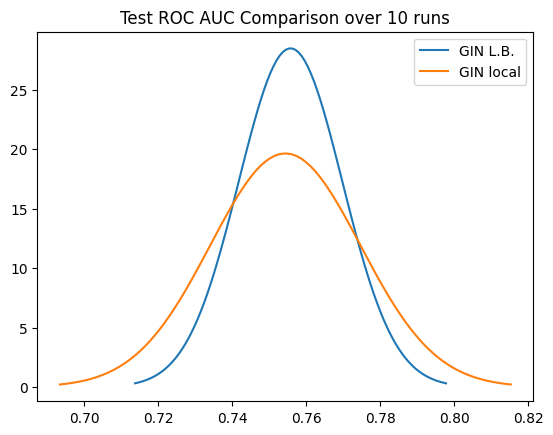

In [36]:
# This comparison only makes sense if using ~100 epochs during training
val_auc_lb = 0.8232
val_auc_lb_std = 0.0090
test_auc_lb = 0.7558
test_auc_lb_std = 0.0140

norm_plot([
    (test_auc_lb, test_auc_lb_std, "GIN L.B."),
    (0.7544, 0.0203, 'GIN local'),
], 'Test ROC AUC Comparison over 10 runs')

In [ ]:
# further reading
# https://arxiv.org/abs/1704.01212